### Identifying State Transitions in Melanoma During Drug-Induced Idling
C Heiser, Spring 2019  
  
---
The purpose of this work is to use cell lineage tracing via molecular barcodes and single-cell transcriptomic analyses to identify population-level heterogeneity and cell-state plasticity in BRAF-mutated melanoma (SKMEL5). 

Requirements:  
[`codyheiser/seq-tools/`](https://github.com/codyheiser/seq-tools)

In [1]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *
sys.path.append('../seq-tools/'); from seq_analysis import * # clone codyheiser/seq-tools and source file

%matplotlib inline

Using TensorFlow backend.


### 0. Confirm Barcode Abundance
---
Lineage barcodes are detected in scRNA-seq by poly-T capture of transcribed barcode mRNA. A targeted amplicon sequencing panel was developed to query genomic barcode content to determine global abundance in population, which should corroborate the cell number (*n_cells*) associated with each barcode in scRNA-seq dataset.  

Read in scRNA-seq data with associated barcode UMIs

In [2]:
%%time
# create fcc_DRs.RNA_seq objects for untreated and idling cells
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 32.1 s, sys: 4.85 s, total: 37 s
Wall time: 38.1 s


Normalize barcode counts within each scRNA-seq set 

In [3]:
U_RNA_counts = pd.DataFrame(U.barcode_counts(IDs='all'))
U_RNA_counts_norm = U_RNA_counts.div(U_RNA_counts.sum(axis=0), axis=1) # get fractional counts

In [4]:
I_RNA_counts = pd.DataFrame(I.barcode_counts(IDs='all'))
I_RNA_counts_norm = I_RNA_counts.div(I_RNA_counts.sum(axis=0), axis=1) # get fractional counts

Read in associated __Read 1__ barcode assay results files, where barcodes were extracted using  
[`codyheiser/seq-tools/seq_extraction.sh`](https://github.com/codyheiser/seq-tools)

In [5]:
%%time
U_R1 = pd.read_csv(gzip.open('untreated/2898-CH-1-CGAAACAT-GTTCAGAG_S1_R1_001.txt.gz'), sep='\t', header=None)
I_R1 = pd.read_csv(gzip.open('idling/2898-CH-2-GGCCACAT-GTTCAGAG_S2_R1_001.txt.gz'), sep='\t', header=None)

CPU times: user 13.1 s, sys: 626 ms, total: 13.7 s
Wall time: 13.9 s


Read in associated __Read 2__ barcode assay results files, where barcodes were extracted using  
[`codyheiser/seq-tools/seq_extraction.sh`](https://github.com/codyheiser/seq-tools)  
and [`codyheiser/seq-tools/rev_comp.sh`](https://github.com/codyheiser/seq-tools)

In [6]:
%%time
U_R2 = pd.read_csv(gzip.open('untreated/2898-CH-1-CGAAACAT-GTTCAGAG_S1_R2_001_REVCOMP.txt.gz'), sep='\t', header=None)
I_R2 = pd.read_csv(gzip.open('idling/2898-CH-2-GGCCACAT-GTTCAGAG_S2_R2_001_REVCOMP.txt.gz'), sep='\t', header=None)

CPU times: user 12.6 s, sys: 673 ms, total: 13.3 s
Wall time: 13.5 s


Now add UMIs from __Read 1__ and __Read 2__ to get totals

In [7]:
U_bc = U_R1.append(U_R2)
I_bc = I_R1.append(I_R2)

Count unique barcode abundances in untreated and idling datasets

In [8]:
U_bc_counts = pd.DataFrame(U_bc[0].value_counts())
U_bc_counts.rename(index=str, columns={0: "Count"}, inplace=True)

In [9]:
I_bc_counts = pd.DataFrame(I_bc[0].value_counts())
I_bc_counts.rename(index=str, columns={0: "Count"}, inplace=True)

Finally, convert counts to fractions of total to normalize for comparison with scRNA-seq data

In [10]:
U_bc_counts_norm = U_bc_counts.div(U_bc_counts.sum(axis=0), axis=1)
I_bc_counts_norm = I_bc_counts.div(I_bc_counts.sum(axis=0), axis=1)

---
Merge scRNA-seq and targeted barcode assay datasets on barcode and print overlay

In [11]:
U_totalcounts = U_RNA_counts_norm.merge(U_bc_counts_norm, left_index=True, right_index=True, how='inner')
U_totalcounts.rename(columns={'Barcode':'U_RNA', 'Count':'U_BC'}, inplace=True)

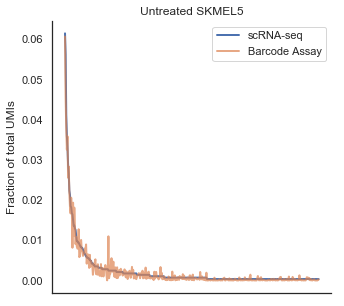

In [12]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(5,5))
U_totalcounts['U_RNA'].plot(label='scRNA-seq', legend=True, linewidth=2)
U_totalcounts['U_BC'].plot(label='Barcode Assay', legend=True, linewidth=2, alpha=0.7)
plt.title('Untreated SKMEL5')
plt.ylabel('Fraction of total UMIs')
sns.despine()
plt.show()

In [13]:
I_totalcounts = I_RNA_counts_norm.merge(I_bc_counts_norm, left_index=True, right_index=True, how='inner')
I_totalcounts.rename(columns={'Barcode':'I_RNA', 'Count':'I_BC'}, inplace=True)

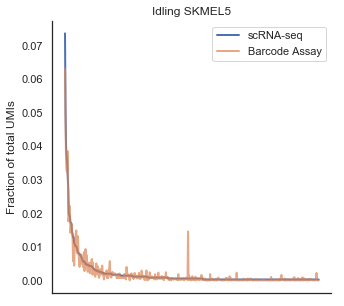

In [14]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(5,5))
I_totalcounts['I_RNA'].plot(label='scRNA-seq', legend=True, linewidth=2)
I_totalcounts['I_BC'].plot(label='Barcode Assay', legend=True, linewidth=2, alpha=0.7)
plt.title('Idling SKMEL5')
plt.ylabel('Fraction of total UMIs')
sns.despine()
plt.show()

Targeted barcode assay __corroborates barcode abundance__ from scRNA-seq results.  
We can confidently trust UMI counts for barcodes in RNA-seq data and use barcode subpopulations to investigate cell state transitions.

### 1. Perform Combined Dimensionality Reduction
---
See if we can detect unique population states in _untreated_ (U) and _idling_ (I) datasets by analyzing together

In [5]:
# combine untreated and idling data to perform combined DR
counts = U.data.append(I.data)

In [6]:
# combine barcode arrays for untreated and idling data
codes = pd.DataFrame(U.barcodes).append(pd.DataFrame(I.barcodes))
codes['Cell Barcode'] = codes.index
codes = codes[~codes.index.duplicated(keep='first')] 
# some cell IDs (not lineage) are duplicated across datasets
# ignore these for this combined analysis, but keep all cell IDs when you split them up

In [7]:
# generate RNA_counts obj with combined data
counts_obj = RNA_counts(data=counts, barcodes=codes) 

In [8]:
# check shape of final counts matrix
counts_obj.data.shape

(6410, 25370)

6410 cells by 25370 genes

In [9]:
# select 500 most variable genes in entire population to prime UMAP analysis
%time counts_vg = RNA_counts.var_select(counts_obj=counts_obj, n_features=500)

CPU times: user 2.73 s, sys: 2.61 s, total: 5.34 s
Wall time: 5.73 s


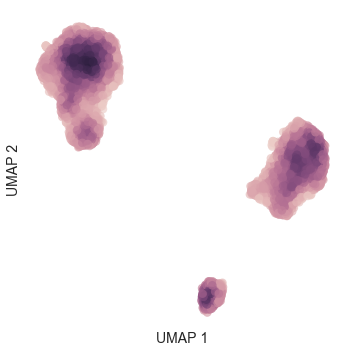

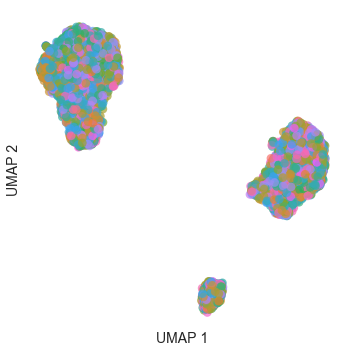

CPU times: user 34.8 s, sys: 1.01 s, total: 35.8 s
Wall time: 35.1 s


In [10]:
%%time
# perform UMAP on total dataset
# normalize using arcsinh() of fractional counts (norm='l1')
# standard perplexity (or n_neighbors) value of 30
counts_UMAP = fcc_UMAP(matrix=counts_vg.arcsinh_norm('l1'), barcodes=counts_obj.barcodes, perplexity=30)
counts_UMAP.plot() # get density plot
counts_UMAP.plot_barcodes() # get barcode overlay

Lineage barcodes are distributed seemingly randomly throughout the population.  
Now color by treatment group:

In [11]:
U_codes = pd.DataFrame(U.barcodes)
U_codes['Barcode'] = 'Untreated'
I_codes = pd.DataFrame(I.barcodes)
I_codes['Barcode'] = 'Idling'
# combine barcode arrays for untreated and idling data
codes = U_codes.append(I_codes)
codes = pd.DataFrame(codes)
codes['Cell Barcode'] = codes.index

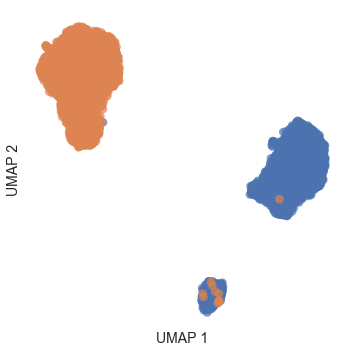

In [12]:
plt.figure(figsize=(5,5))
sns.scatterplot(counts_UMAP.results[:,0], counts_UMAP.results[:,1], s=75, alpha=0.7, hue=codes['Barcode'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

_Untreated_ and _Idling_ cells cluster pretty well.

---
Let's look at upregulation of cell cycle genes to check for cell division clusters

In [13]:
# read in cell cycle genes
cell_cycle = pd.read_csv('resources/metadata_combined.csv')

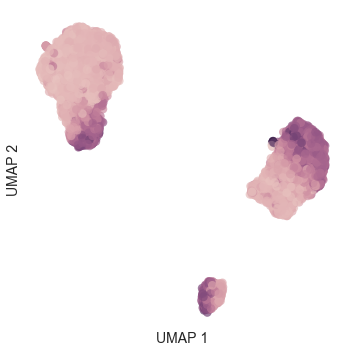

In [14]:
plt.figure(figsize=(5,5))
sns.scatterplot(counts_UMAP.results[:,0], counts_UMAP.results[:,1], s=75, alpha=0.7, hue=cell_cycle['G2M.Score']+cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

Interesting result. The lump on the Idling cluster seems to be more discrete than G2M/S phase cells in the untreated clusters.  
__TODO:__ perform regression of cell cycle genes to see how it affects output, if at all

### 2. Perform Dimensionality Reduction on Separated treatment datasets
---


Determine high-abundance barcodes to use in both datasets

In [15]:
top20 = list(range(1,21))

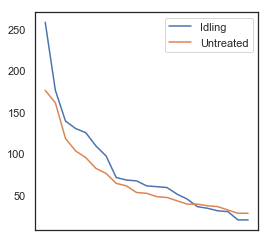

In [16]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
I.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Idling', legend=True)
U.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Untreated', legend=True)
plt.show()

In [17]:
# get list of codes to use throughout the rest of analysis
# top 20 codes in Untreated control set
selected_codes = U.top_barcodes(top20)

Select variable genes in each dataset to prime DRs

In [18]:
# select 500 most variable genes
U_vg = RNA_counts.var_select(counts_obj=U, n_features=500)
I_vg = RNA_counts.var_select(counts_obj=I, n_features=500)

Perform PCA on feature-selected datasets to determine how much variability is explained by PCs

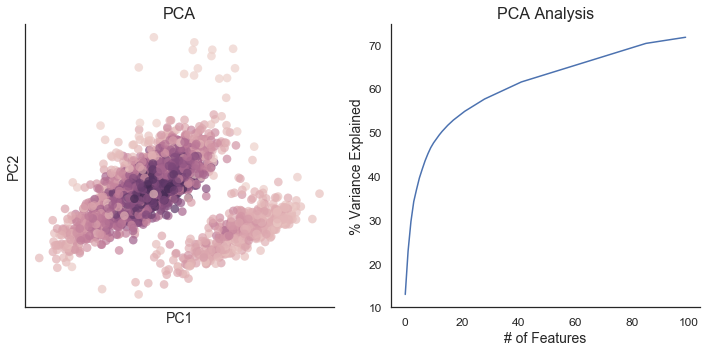

CPU times: user 2.05 s, sys: 186 ms, total: 2.24 s
Wall time: 1.66 s


In [19]:
%%time
U_vg_PCA = fcc_PCA(matrix=U_vg.arcsinh_norm(norm='l1'), barcodes=U_vg.barcodes, n_components=100)
U_vg_PCA.plot()

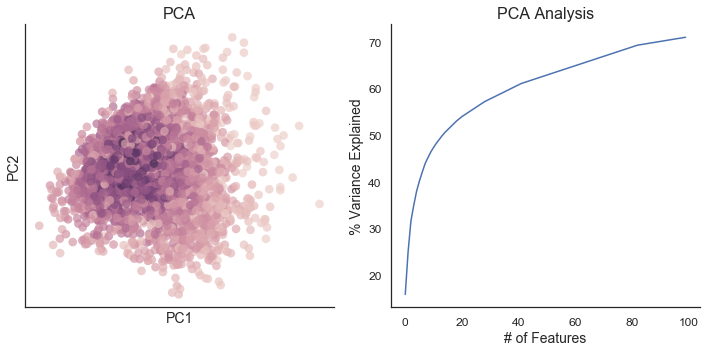

CPU times: user 2.64 s, sys: 191 ms, total: 2.83 s
Wall time: 2.25 s


In [20]:
%%time
I_vg_PCA = fcc_PCA(matrix=I_vg.arcsinh_norm(norm='l1'), barcodes=I_vg.barcodes, n_components=100)
I_vg_PCA.plot()

70+% of variability is accounted for with 100 PCs.  Good dimensionality to run UMAP with.  

---
arcsinh()-normalize to fractional counts in feature-selected dataset and perform UMAP projection

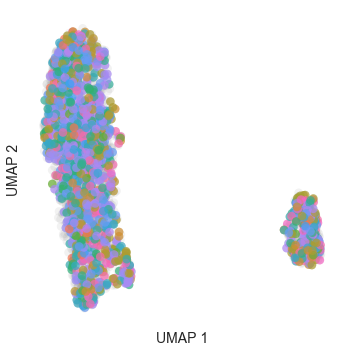

CPU times: user 10.6 s, sys: 466 ms, total: 11.1 s
Wall time: 10.7 s


In [21]:
%%time
U_vg_UMAP = fcc_UMAP(matrix=U_vg.arcsinh_norm(norm='l1'), barcodes=U_vg.barcodes, perplexity=30)
U_vg_UMAP.plot_barcodes(ranks=selected_codes) # plot codes from selected list

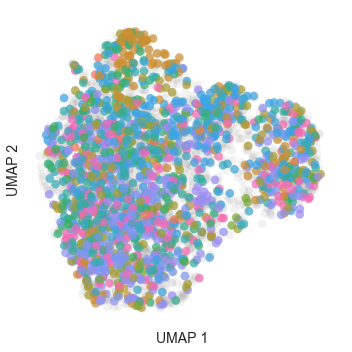

CPU times: user 13.1 s, sys: 616 ms, total: 13.7 s
Wall time: 13.7 s


In [23]:
%%time
I_vg_UMAP = fcc_UMAP(matrix=I_vg.arcsinh_norm(norm='l1'), barcodes=I_vg.barcodes, perplexity=30)
I_vg_UMAP.plot_barcodes(ranks=selected_codes) # plot codes from selected list

--- 
Look at cell cycle genes again in each dataset for good measure

In [24]:
U_cell_cycle = pd.read_csv('untreated/untreated_metadata.csv')
I_cell_cycle = pd.read_csv('idling/treated_metadata.csv')
U_cell_cycle.rename(columns={'Unnamed: 0':'Cell Barcode'}, inplace=True)
I_cell_cycle.rename(columns={'Unnamed: 0':'Cell Barcode'}, inplace=True)

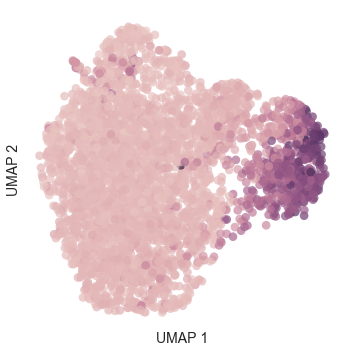

In [25]:
plt.figure(figsize=(5,5))
sns.scatterplot(I_vg_UMAP.results[:,0], I_vg_UMAP.results[:,1], s=75, alpha=0.7, hue=I_cell_cycle['G2M.Score']+I_cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

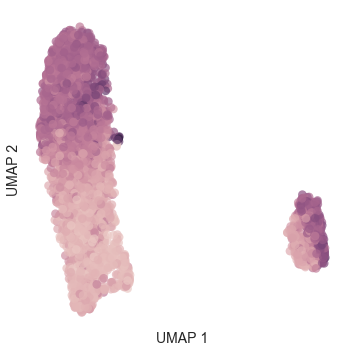

In [26]:
plt.figure(figsize=(5,5))
sns.scatterplot(U_vg_UMAP.results[:,0], U_vg_UMAP.results[:,1], s=75, alpha=0.7, hue=U_cell_cycle['G2M.Score']+U_cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

### 3. Calculate EMD Values from Null Population for High-Abundance Clones
---


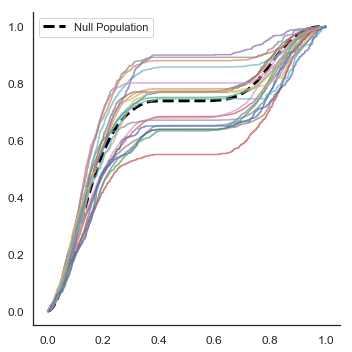

CPU times: user 32.2 s, sys: 1.07 s, total: 33.2 s
Wall time: 33.2 s


In [27]:
%%time
U_out_vg_UMAP = compare_barcode_distances(obj=U_vg_UMAP, barcodes=selected_codes)

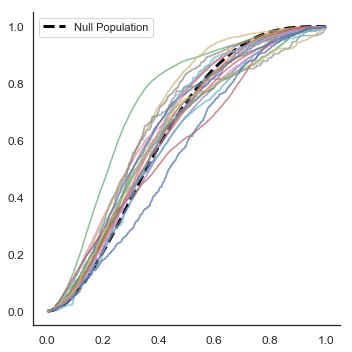

CPU times: user 52.2 s, sys: 2.51 s, total: 54.7 s
Wall time: 58.1 s


In [28]:
%%time
I_out_vg_UMAP = compare_barcode_distances(obj=I_vg_UMAP, barcodes=selected_codes)

### 4. Create Confidence Interval to Assign Significance to EMD Values
---
Build bias curve of EMD values for random permutations of cells corresponding to range of clonal abundances in datasets.  
Then fit a regression and assign an upper 95% confidence bound function to calculate significance threshold based on *n_cells* in each clonal subpopulation.

In [29]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_vg_UMAP = cell_bias_curve(obj=U_vg_UMAP, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 59s, sys: 7.88 s, total: 4min 7s
Wall time: 4min 11s


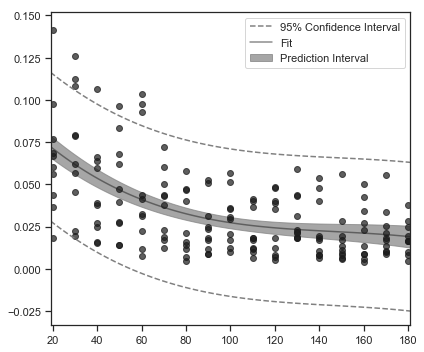

In [30]:
# plot polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_vg_UMAP.melt(id_vars='n_cells')['value'], deg=3)
# degree of polynomial is chosen arbitrarily
# TODO: determine lowest degree polynomial fit for each dataset

Do the same as above for __Idling__ dataset

In [31]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_vg_UMAP = cell_bias_curve(obj=I_vg_UMAP, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 37s, sys: 9.27 s, total: 4min 46s
Wall time: 4min 48s


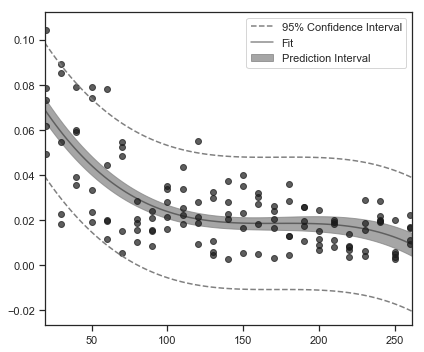

In [36]:
# plot polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_vg_UMAP.melt(id_vars='n_cells')['value'], deg=3)
# degree of polynomial is chosen arbitrarily
# TODO: determine lowest degree polynomial fit for each dataset

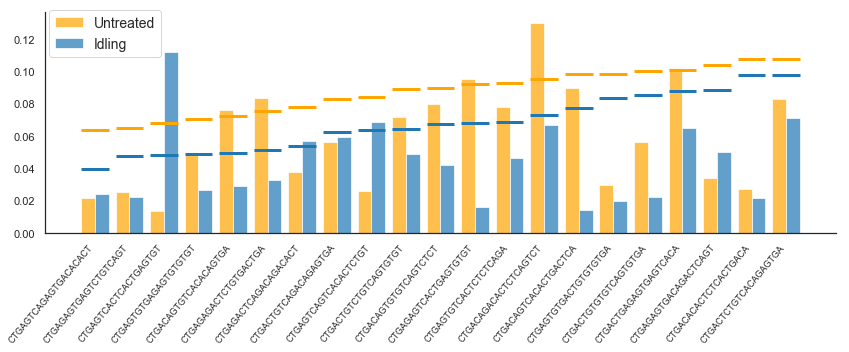

In [37]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out_vg_UMAP.code, height=U_out_vg_UMAP.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out_vg_UMAP.code, height=I_out_vg_UMAP.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_vg_UMAP.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_vg_UMAP.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc=[0.005,0.8],fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
Look at some significant barcode populations

First, significant idling populations:

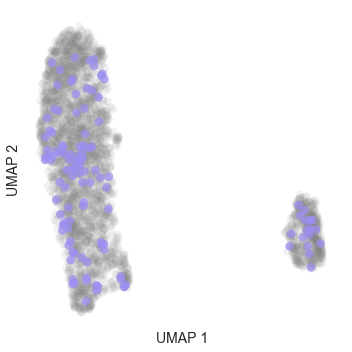

In [38]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[2]])

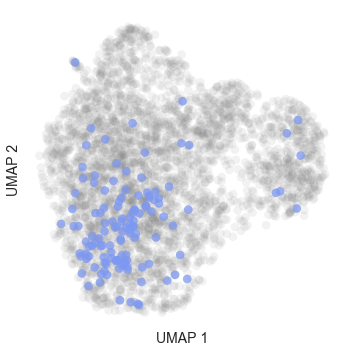

In [39]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[2]])

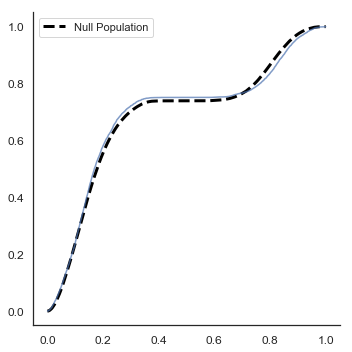

CPU times: user 2.43 s, sys: 277 ms, total: 2.71 s
Wall time: 2.52 s


,EMD,KLD,code
0,0.013835,6.425546,CTGAGTCACTCACTGAGTGT


In [40]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[2]])

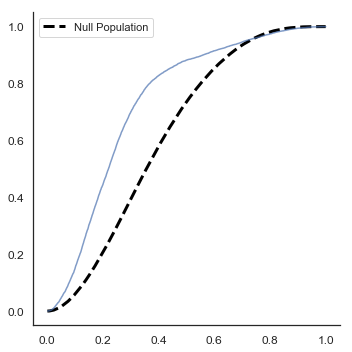

CPU times: user 3.52 s, sys: 370 ms, total: 3.89 s
Wall time: 3.77 s


,EMD,KLD,code
0,0.111841,6.777371,CTGAGTCACTCACTGAGTGT


In [41]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[2]])

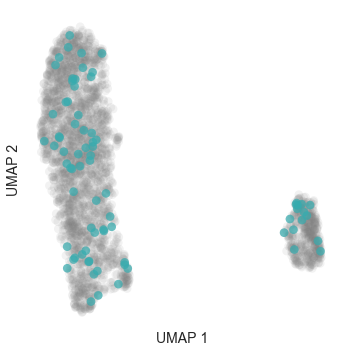

In [61]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[6]])

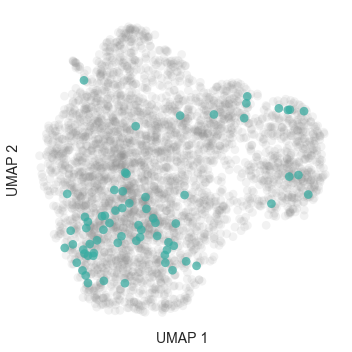

In [60]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[6]])

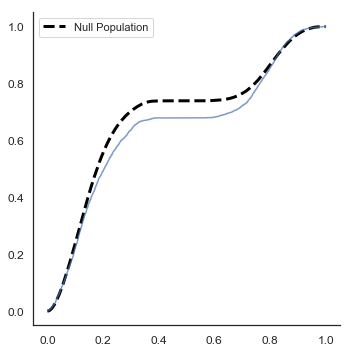

CPU times: user 2.51 s, sys: 260 ms, total: 2.77 s
Wall time: 2.56 s


,EMD,KLD,code
0,0.037562,7.260362,CTGAGACTCAGACAGACACT


In [59]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[6]])

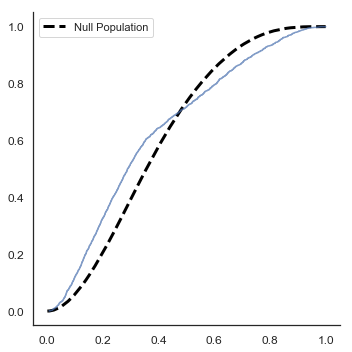

CPU times: user 3.66 s, sys: 326 ms, total: 3.98 s
Wall time: 3.74 s


,EMD,KLD,code
0,0.056631,8.029464,CTGAGACTCAGACAGACACT


In [58]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[6]])

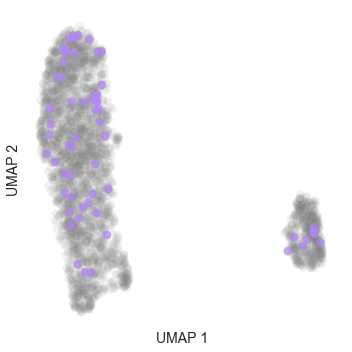

In [42]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[8]])

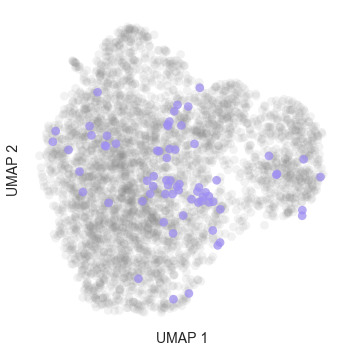

In [43]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[8]])

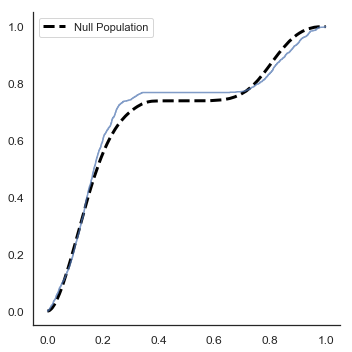

CPU times: user 2.38 s, sys: 238 ms, total: 2.62 s
Wall time: 2.41 s


,EMD,KLD,code
0,0.02582,7.762147,CTGAGTCAGTCACACTCTGT


In [44]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[8]])

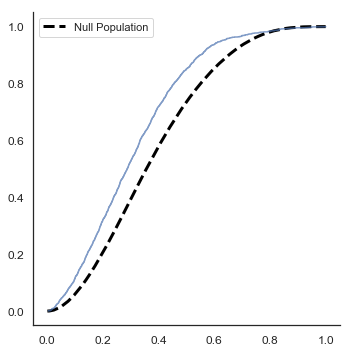

CPU times: user 3.69 s, sys: 384 ms, total: 4.08 s
Wall time: 3.9 s


,EMD,KLD,code
0,0.068323,7.946677,CTGAGTCAGTCACACTCTGT


In [45]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[8]])

...and significant untreated populations:

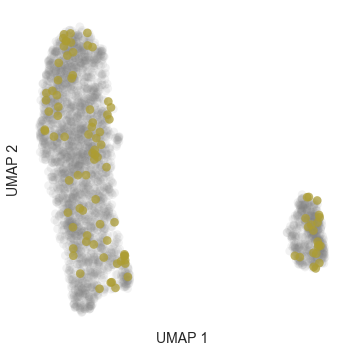

In [50]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[4]])

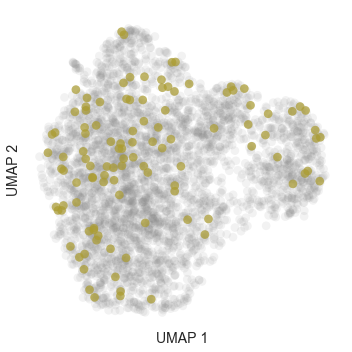

In [51]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[4]])

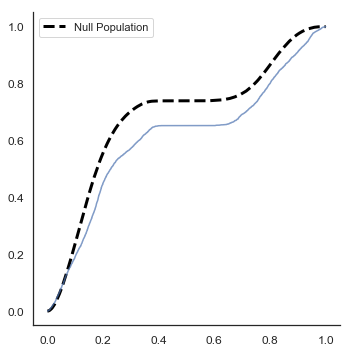

CPU times: user 2.42 s, sys: 239 ms, total: 2.66 s
Wall time: 2.43 s


,EMD,KLD,code
0,0.076133,6.790229,CTGACAGTGTCACACAGTGA


In [52]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[4]])

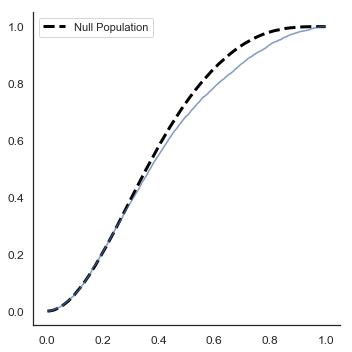

CPU times: user 3.68 s, sys: 362 ms, total: 4.05 s
Wall time: 4 s


,EMD,KLD,code
0,0.028916,6.983051,CTGACAGTGTCACACAGTGA


In [53]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[4]])

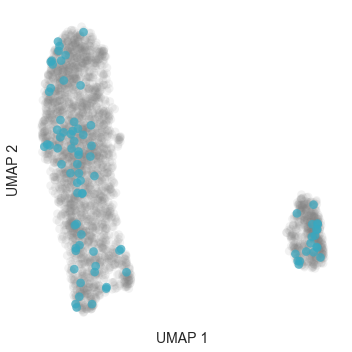

In [46]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[5]])

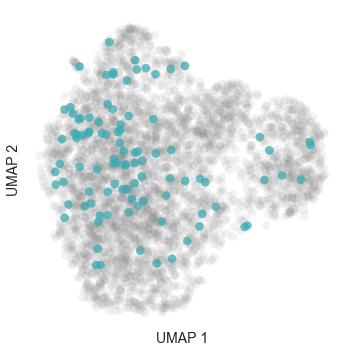

In [47]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[5]])

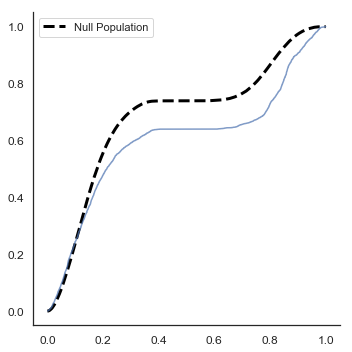

CPU times: user 2.58 s, sys: 477 ms, total: 3.06 s
Wall time: 2.88 s


,EMD,KLD,code
0,0.08329,7.129005,CTGAGAGACTCTGTGACTGA


In [48]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[5]])

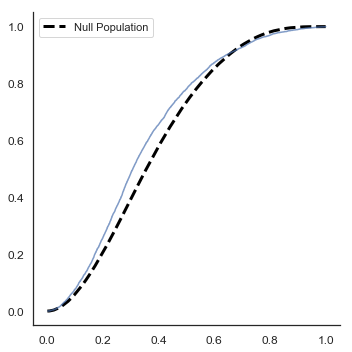

CPU times: user 3.75 s, sys: 380 ms, total: 4.13 s
Wall time: 4.11 s


,EMD,KLD,code
0,0.03274,7.223303,CTGAGAGACTCTGTGACTGA


In [49]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[5]])

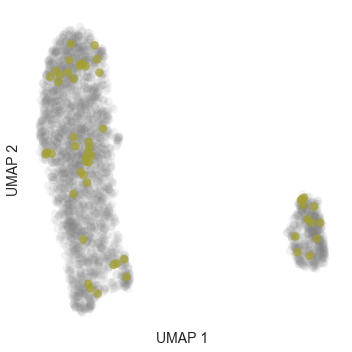

In [54]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[10]])

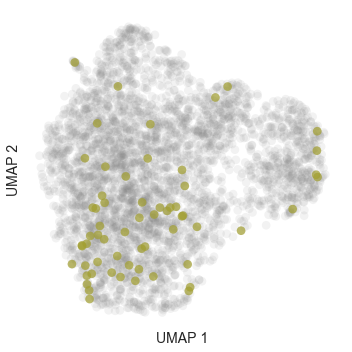

In [55]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[10]])

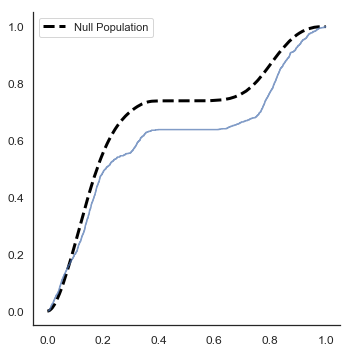

CPU times: user 2.49 s, sys: 250 ms, total: 2.74 s
Wall time: 2.58 s


,EMD,KLD,code
0,0.079895,8.025601,CTGACAGTGTGTCAGTCTCT


In [56]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[10]])

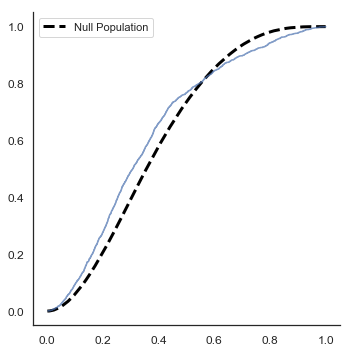

CPU times: user 3.68 s, sys: 338 ms, total: 4.02 s
Wall time: 3.81 s


,EMD,KLD,code
0,0.041892,8.184706,CTGACAGTGTGTCAGTCTCT


In [57]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[10]])

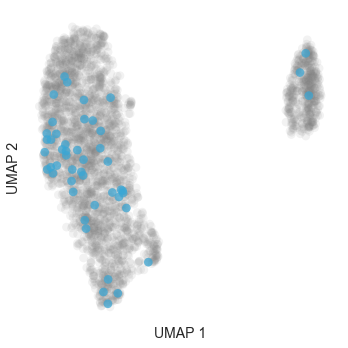

In [94]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[11]])

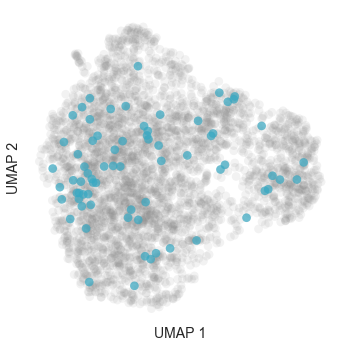

In [121]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[11]])

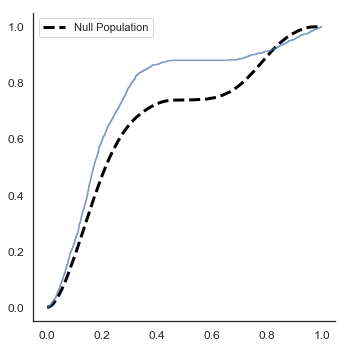

CPU times: user 2.41 s, sys: 264 ms, total: 2.67 s
Wall time: 2.52 s


,EMD,KLD,code
0,0.087073,8.248442,CTGAGAGTCACTGAGTGTGT


In [162]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[11]])

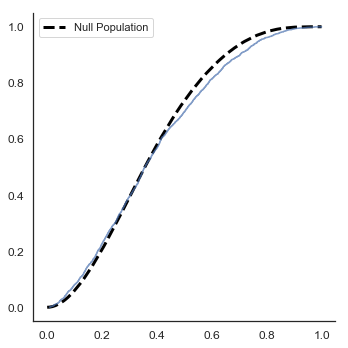

CPU times: user 3.57 s, sys: 397 ms, total: 3.97 s
Wall time: 3.77 s


,EMD,KLD,code
0,0.019371,7.848853,CTGAGAGTCACTGAGTGTGT


In [163]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[11]])

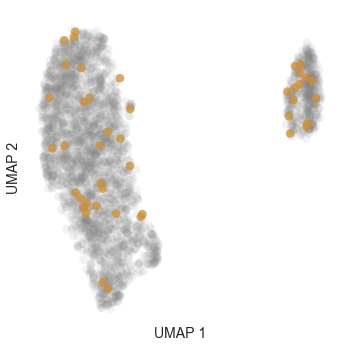

In [95]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[13]])

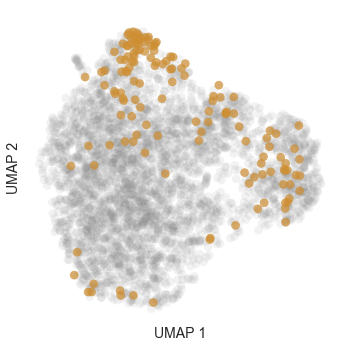

In [123]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[13]])

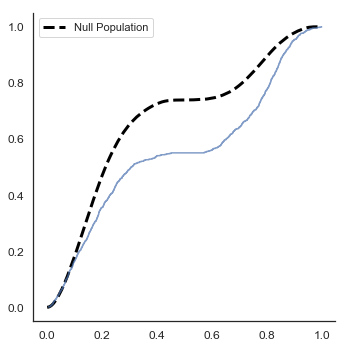

CPU times: user 2.4 s, sys: 305 ms, total: 2.71 s
Wall time: 2.54 s


,EMD,KLD,code
0,0.115036,8.393087,CTGACAGACACTCTCAGTCT


In [158]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[13]])

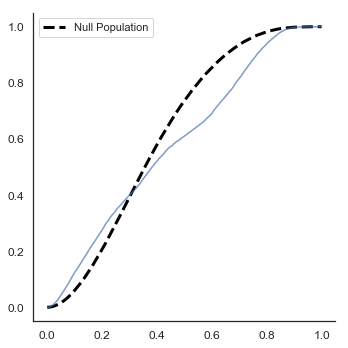

CPU times: user 3.62 s, sys: 360 ms, total: 3.98 s
Wall time: 3.82 s


,EMD,KLD,code
0,0.065948,6.542854,CTGACAGACACTCTCAGTCT


In [159]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[13]])